# Women in chess

The objective of this notebook is to analyze possible causes of the lower rating of women in chess compared to men. 
There are several questions I want to address:
- evolution of the percentage of women playing chess in the last years
- rating difference between men and women in the last years
- number of women at top level at different ages and/or along last years

## Data preparation

I have a file for each of the last 15 years with the ranking of all the rated players in the world. I read each file and calculate for each year the percentage of women playing and the mean rating of both men and women.

In [3]:
#import packages
import pandas as pd
import os
from plotnine import *

In [4]:
#This chunk reads the fide ranking files from 2005 to 2021 and shows the proportion of women in ches and the
#mean rating per sex

#FIDE files have 2 different formats. Files with each format are in a different folder
#Read files with old format
old_names = os.listdir("data\old_format")

df_list_number = []#Stores the percentage of women
df_list_elo = []#Stores the mean rating

for name in old_names:
    year = name[3:5]#Get year from file name
    data = pd.read_fwf(f'data\old_format\{name}', delimiter=' ')
    #Split the data in men and women
    data_w = data.loc[(data.Flag == "w") | (data.Flag == "wi")]
    data_m = data.loc[(data.Flag != "w") & (data.Flag != "wi")]
    #Calculate percentage of men and women
    percent_w = data_w.shape[0] / data.shape[0] *100
    percent_m = 100 - percent_w
    #Calculate the mean rating of men and women
    elo_w = data_w.iloc[:,3 ].mean()
    elo_m = data_m.iloc[:,3 ].mean()
    #Add info to the lists as a dictionary
    df_list_number.append({"year": "20" + str(year), "percent": percent_w, "Sex": "Women"})
    df_list_number.append({"year": "20" + str(year), "percent": percent_m, "Sex": "Men"})
    df_list_elo.append({"year": "20" + str(year), "elo": elo_w, "Sex": "Women"})
    df_list_elo.append({"year": "20" + str(year), "elo": elo_m, "Sex": "Men"})

#Read files with new format
new_names = os.listdir("data\\new_format")

for name in new_names:
    year = pd.to_numeric(name[12:14])#Get year from file name
    if year < 17:#Format changed after 16, adding one column. This selects the right column for ranking
        num = 7
    else:
        num=8
    data = pd.read_fwf(f'data\\new_format\{name}', delimiter=' ')
    data.iloc[:, num] = pd.to_numeric(data.iloc[:, num], errors="coerce")
    #Splits data in men and women
    data_w = data.loc[data.Sex == "F"]
    data_m = data.loc[data.Sex == "M"]
    #Calculate the percentage of men and women
    percent_w = data_w.shape[0] / data.shape[0] * 100
    percent_m = 100 - percent_w
    #Calculate mean rating for men and women
    elo_w = data_w.iloc[:,num].mean()
    elo_m = data_m.iloc[:,num].mean()
    #Append data to the lists as a dictionary
    df_list_number.append({"year": "20" + str(year), "percent": percent_w, "Sex": "Women"})
    df_list_number.append({"year": "20" + str(year), "percent": percent_m, "Sex": "Men"})
    df_list_elo.append({"year": "20" + str(year), "elo": elo_w, "Sex": "Women"})
    df_list_elo.append({"year": "20" + str(year), "elo": elo_m, "Sex": "Men"})

#Convert lists of dictionaries into dataframes
df_number = pd.DataFrame(df_list_number, columns= ["year", "percent", "Sex"])
df_elo = pd.DataFrame(df_list_elo, columns= ["year", "elo", "Sex"])

#Convert year into numeric and sort for a better visualization
df_number.year = pd.to_numeric(df_number.year)
df_number = df_number.sort_values("year")
df_elo.year = pd.to_numeric(df_elo.year)
df_elo = df_elo.sort_values("year")

## Percentage of women playing chess

The next plot shows the percentage of women playing chess each year.

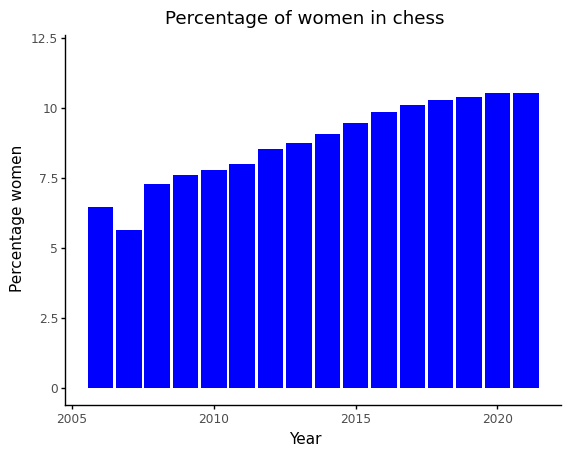

<ggplot: (122796335339)>

In [13]:
#Plot percentage of women per year
ggplot(df_number[df_number.Sex == "Women"], aes(x="year", y="percent")) + \
    geom_bar(stat="identity", fill = "Blue") + \
    labs(x="Year", y= "Percentage women", title = "Percentage of women in chess") + \
    coord_cartesian(ylim=(0, 12)) + \
    theme_classic()


We can see a clear increase in the percentage of women per year. The proportion almost doubles in the last 15 years.

## Rating difference between men and women

Plot the mean ranking for men and women in the last 15 years.

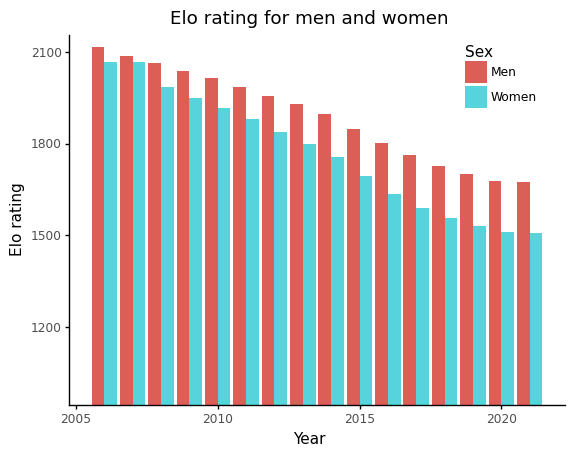

<ggplot: (122676705853)>

In [7]:
#Plot mean rating in men and women per year
ggplot(df_elo, aes(x="year", y = "elo", fill="Sex")) + \
    geom_bar(stat="identity", position = "dodge") + \
    labs(x="Year", y="Elo rating", title="Elo rating for men and women") + \
    coord_cartesian(ylim=(1000, 2100) )+ \
    theme_classic() + \
    theme(legend_position = (0.8, 0.8))


The first striking result is that the rating of both men and women has decreased greatly. This is due to the fact that the rating used to have a floor (lowest possible value) of 2000 points in 2005. This floor was progresively reduced in the last years. 
The rating difference between men and women seems to have increased from 2005 to 2021, but this floor rating is probably affecting the calculations. 

## Women representation in top 100 by age

I want to see what is the number of women among the top players in the world at different ages, and how it has changed in the last years. To make it I compute the number of women among the top 100 players at different ages and during different years (2005, 2011, 2016 and 2021).

In [8]:
#First I need to read and prepare the data. FIDE used a format to store data until 2012 and a different one from 2013.
#I create functions to read these 2 different formats
#Read old format

def read_old_format(name, year, col):
    """Reads a file with the FIDE old format and prepares the datafrade for analysis

        Variables:
        name: name of the file
        year: which year the file belong
        col: name of the column that store the rating
    """
    file = "data\old_format\\" + name
    data = pd.read_fwf(file, delimiter=' ')
    #Number of games and year of birth are incorrectly read in only one column
    #Split the column in 2 and change the type to numeric
    data[['games', 'year']] = data.GamesBorn.str.split("  ", expand=True, )
    data["year"] = pd.to_numeric(data["year"])
    data["games"] = pd.to_numeric(data["games"])
    #Add a new column with the age of the player
    data["age"] = year - data["year"]
    #Remove players without rating
    data.dropna(subset=[col], inplace=True)

    return (data)

#Read data for files from 2006 and 2011
data06 = read_old_format("JUL06FRL.TXT", 2006, "Jul06")
data11 = read_old_format("may11frl.txt", 2011, "May10")


#Read new format

def read_new_format(name, year, col):
    """Reads a file with the FIDE new format and prepares the datafrade for analysis
            Variables:
            name: name of the file
            year: which year the file belong
            col: name of the column that store the rating
        """
    file = "data\\new_format\\" + name
    data = pd.read_fwf(file, delimiter=' ')
    #B-day column can cause problems because of "-". Rename and make it numeric
    data.rename(columns={"B-day": "year"}, inplace = True)
    data["year"] = pd.to_numeric(data["year"], errors="coerce")
    data[col] = pd.to_numeric(data[col], errors="coerce")#Make ranking column numeric
    data["age"] = year - data["year"]

    return(data)

#Read data from files from 2016 and 2020
data16 = read_new_format("standard_may16frl.TXT", 2016, "MAY16")
data21 = read_new_format("standard_mar21frl.TXT", 2021, "MAR21")


In [9]:
##Percentage of women in total number of players or top100 players at different ages

#Create empty lists to store the data
df_list_top100 = []#Store data for top100 players
df_list_total = []#Store data for total number of players
#Select the ages
ages = list(range(11, 44, 3))

def top100_by_age(df_info, year, col):
    """Calculates the percentage of women in the total number of players or in the top100 players at different ages
        Global variables:
            df_list_top100: list where data for top100 players will be stored
            df_list_total: list where data for total number of players will be stored
            ages: list of ages to calculate the number of women

        Local variables:
            df_info: dataframe that stores the informatio
            year: year where the information was taken
            col: name of the column with the rating
            """
    global ages, df_list
    #Remove inactive players
    data = df_info[df_info.Flag != "i"]
    data = data[data.Flag != "wi"]

    for age in ages:
        data_by_age = data[data["age"] < age]#Select the desired players
        #Create a new dataframe with data from the top 100
        data_top100 = data_by_age.sort_values(col, ascending=False)
        data_top100 = data_top100.head(100)
        #The if clause differentiates between the 2 different formats
        if year > 2012:
            #Calculate the percentage in top100 and in total
            percentage_top100 = data_top100[data_top100["Sex"] == "F"].shape[0]
            percentage_total = data_by_age[data_by_age["Sex"] == "F"].shape[0] / data_by_age.shape[0]
        else:
            percentage_top100 = data_top100[data_top100["Flag"] == "w"].shape[0]
            percentage_total = data_by_age[data_by_age["Flag"] == "w"].shape[0] / data_by_age.shape[0]
        #Append the data to a list of dictionaries
        df_list_top100.append(
            {"age": "under " + str(age), "percentage": percentage_top100, "year": year})
        df_list_total.append(
            {"age": "under " + str(age), "percentage": percentage_total, "year": year})

#Calculate the number of women in top 100 for each year
top100_by_age(data21, 2021, "MAR21")
top100_by_age(data16, 2016, "MAY16")
top100_by_age(data11, 2011, "May10")
top100_by_age(data06, 2006, "Jul06")

#Convert list of dictionaries into dataframes
df_top100 = pd.DataFrame(df_list_top100, columns= ["age", "percentage", "year"])
df_total = pd.DataFrame(df_list_total, columns= ["age", "percentage", "year"])


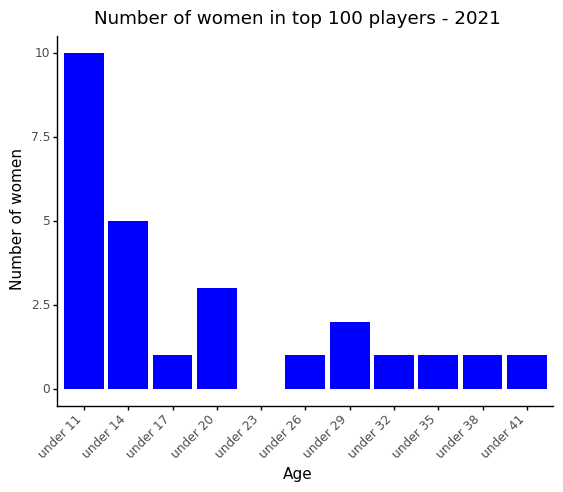

<ggplot: (122793374603)>

In [10]:
#Plot data for top100 for 2021
ggplot(df_top100[df_top100.year == 2021], aes(x="age", y="percentage")) + \
    geom_bar(stat="identity", fill = "Blue") + \
    labs(x="Age", y= "Number of women", title = "Number of women in top 100 players - 2021") + \
    theme_classic() + \
    theme(axis_text_x=element_text(rotation=45, hjust=1))

In the current data, 2021, there is a sharp decrease of women at top level during teenage years. Is this a trend that has happened before?

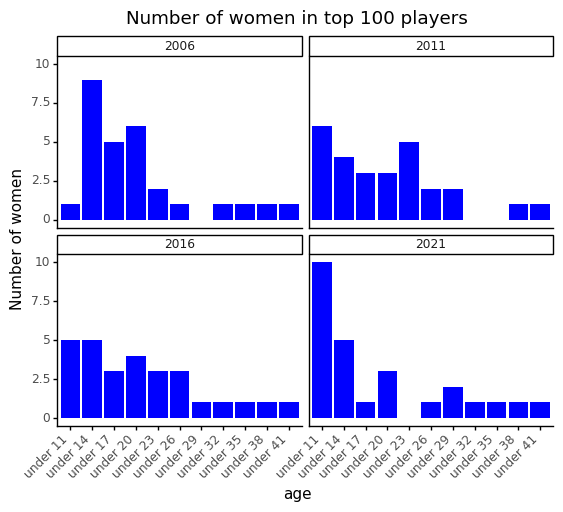

<ggplot: (122792264789)>

In [12]:
#Plot all data for top100
ggplot(df_top100, aes(x="age", y="percentage")) + \
    geom_bar(stat="identity", fill = "Blue") + \
    labs(y= "Number of women", title = "Number of women in top 100 players") + \
    theme_classic() + \
    theme(axis_text_x=element_text(rotation=45, hjust=1)) + \
    facet_wrap ("~year")

It seems like the number of women among top 100 players has been, for the last 15 years, always higher in girls than in adult women. Does it reflect to total number of women playing at different ages?

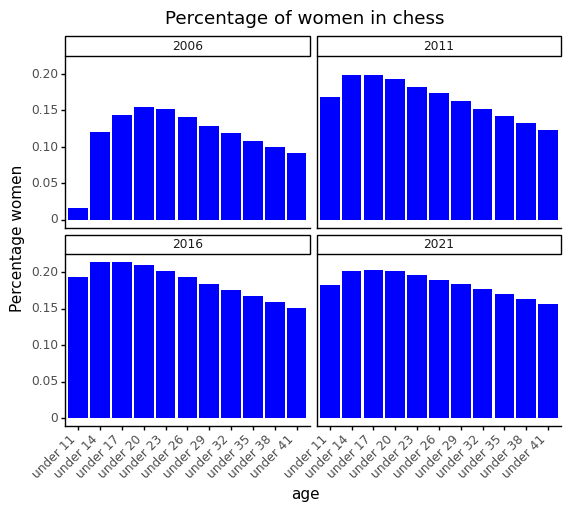

<ggplot: (122791308611)>

In [11]:
#Plot data for total number of players
ggplot(df_total, aes(x="age", y="percentage")) + \
    geom_bar(stat="identity", fill = "Blue") + \
    labs(y= "Percentage women", title = "Percentage of women in chess") + \
    theme_classic() + \
    theme(axis_text_x=element_text(rotation=45, hjust=1)) + \
    facet_wrap ("~year")

Although there is a certain trend that shows that the percentage of women is lower as they grow older, it seems like the drop in top players is stronger than the smooth drop in total players. There must be some reason that takes women away from pursuing a professional career in chess. It is possible that social motives are behind this trend. 